# Load Data

In [104]:
OUTPUT_FOLDER = "/scratch/aakash_ks.iitr/dr-scnn/"
DATA_FOLDER = "/scratch/aakash_ks.iitr/data/diabetic-retinopathy/"
# TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train/'
TRAIN_DATA_FOLDER = DATA_FOLDER + 'resized_train_c/'

# TEST_DATA_FOLDER = DATA_FOLDER + 'test/'

# Imports

In [105]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from PIL import Image

plt.rcParams['figure.dpi'] = 200

In [106]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.transforms import v2

import timm

In [107]:
NUM_CLASSES = 5

class CFG:
    seed = 42
    N_folds = 5
    train_folds = [0] # [0,1,2,3,4]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    apex=True # use half precision
    workers = 16

    model_name = "resnet50.a1_in1k"
    epochs = 10
    cropped = True
    # weights =  torch.tensor([0.206119, 0.793881],dtype=torch.float32)

    clip_val = 1000.
    batch_size = 64
    # gradient_accumulation_steps = 1

    lr = 5e-3
    weight_decay=1e-2
    
    resolution = 224
    samples_per_class = 250

In [108]:
import wandb
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb.login(key=user_secrets.get_secret("wandb_api"))

run = wandb.init(
    project="hello-world", 
    dir=OUTPUT_FOLDER,
    config={
    k:v for k, v in CFG.__dict__.items() if not k.startswith('__')}
)

learning_rate,▁▁
train_accuracy,▁▁
train_auc,▁▁
train_loss,▁▁
train_precision,▁▁
val_accuracy,▁▁
val_auc,▁▁
val_loss,▁▁
val_precision,▁▁
learning_rate,0.00488
train_accuracy,0.26979


In [109]:
device = torch.device(CFG.device)

# Load train data

In [110]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv')).sample(frac=1).reset_index(drop=True)
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,13810,13819,17340_right,0
1,22083,22097,27852_right,0
2,27552,27568,34901_left,4
3,15987,15997,20070_right,0
4,16171,16181,20273_right,0
...,...,...,...,...
35103,16850,16861,21138_right,0
35104,6265,6269,7883_right,3
35105,11284,11291,14181_right,0
35106,860,861,1042_right,0


In [111]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)]
len(train_data)

19944

In [112]:
train_data.level.value_counts()

level
0    14637
2     2982
1     1405
3      498
4      422
Name: count, dtype: int64

In [113]:
# take only 100 samples from each class
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
train_data.level.value_counts()

level
0    250
4    250
3    250
2    250
1    250
Name: count, dtype: int64

# Dataset

In [114]:
from torchvision.transforms import functional as func

class CustomTransform:
    def __init__(self, output_size=(CFG.resolution, CFG.resolution), radius_factor=0.9):
        self.output_size = output_size
        self.radius_factor = radius_factor

    def __call__(self, img):
        # Assuming img is a PIL Image
        # Normalize and preprocess as previously defined
        img = func.resize(img, int(min(img.size) / self.radius_factor))
        img_tensor = func.to_tensor(img)
        mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
        img_normalized = func.normalize(img_tensor, mean.tolist(), std.tolist())
        kernel_size = 15
        padding = kernel_size // 2
        avg_pool = torch.nn.AvgPool2d(kernel_size, stride=1, padding=padding)
        local_avg = avg_pool(img_normalized.unsqueeze(0)).squeeze(0)
        img_subtracted = img_normalized - local_avg
        center_crop_size = int(min(img_subtracted.shape[1:]) * self.radius_factor)
        img_cropped = func.center_crop(img_subtracted, [center_crop_size, center_crop_size])

        # Apply augmentations
        img_resized = func.resize(img_cropped, self.output_size)

        return img_resized

In [115]:
# train_transforms = CustomTransform()

train_transforms = v2.Compose([
    CustomTransform(),
    # v2.RandomResizedCrop(CFG.resolution, scale=(0.8, 1.0)),  # Krizhevsky style random cropping
    v2.RandomHorizontalFlip(),  # Random horizontal flip
    v2.RandomVerticalFlip(),  # Random vertical flip
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2)),  # Gaussian blur with random kernel size and sigma
    v2.RandomRotation(degrees=(0, 90)),  # Random rotation between 0 and 360 degrees
    v2.ToDtype(torch.float32, scale=False),
])

val_transforms = v2.Compose([
    CustomTransform(),
    v2.ToDtype(torch.float32, scale=False),
])

In [116]:
class ImageTrainDataset(Dataset):
    def __init__(
        self,
        folder,
        data,
        transforms,
    ):
        self.folder = folder
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data.loc[index]
        image = Image.open(f"{self.folder}{d.image}.jpeg")
        image = self.transforms(image)
        label = d.level

        return image, torch.tensor(label, dtype=torch.long)

Traceback (most recent call last):
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/multiprocessing/co

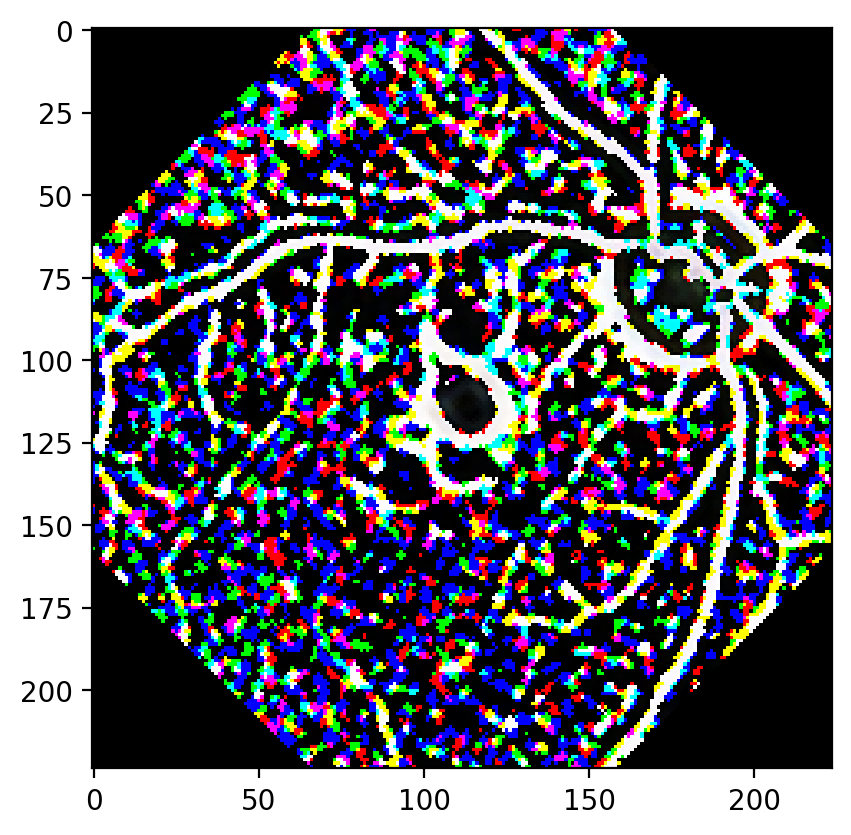

In [117]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, train_transforms)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

# Metric

In [118]:
from sklearn.metrics import f1_score as sklearn_f1
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score

In [119]:
# def find_best_threshold(targets, predictions):
#     score_5 = sklearn_f1(targets, predictions > 0.5)
#     best_score = 0
#     best_th = -1
#     for i in range(100):
#         threshold =  i/100
#         _score = sklearn_f1(targets, predictions > threshold)
#         if _score > best_score:
#             best_score = _score
#             best_th = threshold

#     tn, fp, fn, tp = confusion_matrix(targets.numpy(), predictions.numpy() > best_th).ravel()
#     print(f"tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}")
#     return score_5, best_score, best_th

# Train and evaluate functions

In [120]:
class style:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    END = '\033[0m'
    BOLD = '\033[1m'

In [121]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [122]:
def evaluate_model(cfg, model, data_loader, loss_criterion, epoch=-1):
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.eval()
    val_loss = 0

    targets = []
    predictions = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            logits = model(images)

            loss = loss_fn(logits, target)
            val_loss += loss.item()

            targets.append(target.detach().cpu())
            predictions.append(logits.detach().cpu())
            del images, target, logits

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)

    val_loss /= total_len
    # base_score, best_score, best_th = find_best_threshold(targets, predictions[:, 1])
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: validation loss = {val_loss:.4f} auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return val_loss, roc_auc, accuracy, precision

In [123]:
def train_epoch(cfg, model, train_loader, loss_criterion, optimizer, scheduler, epoch):
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    # loss_fn = nn.CrossEntropyLoss(weight=cfg.weights.to(device), label_smoothing=0.1)
    loss_fn = loss_criterion

    model.train()
    train_loss = 0
    learning_rate_history = []

    targets = []
    predictions = []

    total_len = len(train_loader)
    tk0 = tqdm(enumerate(train_loader), total=total_len)
    for step, (images, labels) in tk0:
        images = images.to(device, non_blocking=True)
        target = labels.to(device, non_blocking=True)

        # https://pytorch.org/blog/accelerating-training-on-nvidia-gpus-with-pytorch-automatic-mixed-precision/
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            logits = model(images)
            loss = loss_fn(logits, target)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.clip_val)

        train_loss += loss.item()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        if scheduler is None:
            lr = optimizer.param_groups[0]['lr']
        else:
            scheduler.step()
            lr = scheduler.get_last_lr()[0]

        tk0.set_description(f"Epoch {epoch} training {step+1}/{total_len} [LR {lr:0.6f}] - loss: {train_loss/(step+1):.4f}")
        learning_rate_history.append(lr)

        targets.append(target.detach().cpu())
        predictions.append(logits.detach().cpu())
        del images, target

    targets = torch.cat(targets, dim=0)
    predictions = torch.cat(predictions, dim=0)
    probabilities = F.softmax(predictions, dim=1)
    
    display(probabilities.shape)
    display(probabilities)

    train_loss /= total_len
    # For multi-class classification, you might need the class with the highest probability
    predicted_classes = predictions.argmax(dim=1)

    roc_auc = roc_auc_score(targets.numpy(), probabilities.numpy(), multi_class='ovo')

    # Calculate accuracy
    accuracy = accuracy_score(targets.numpy(), predicted_classes.numpy())

    precision = precision_score(targets.numpy(), predicted_classes.numpy(), average='weighted')

    print(f'Epoch {epoch}: training loss = {train_loss:.4f} auc = {roc_auc:.4f} accuracy = {accuracy:.4f} precision = {precision:.4f}')
    return train_loss, learning_rate_history, roc_auc, accuracy, precision

# Train model

## Split data

The distribution of classes in the training data is not balance so using StratifiedKFold will ensure that the distrubution of positive and negative samples in all folds will match the original distributions.

/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='level', ylabel='Count'>

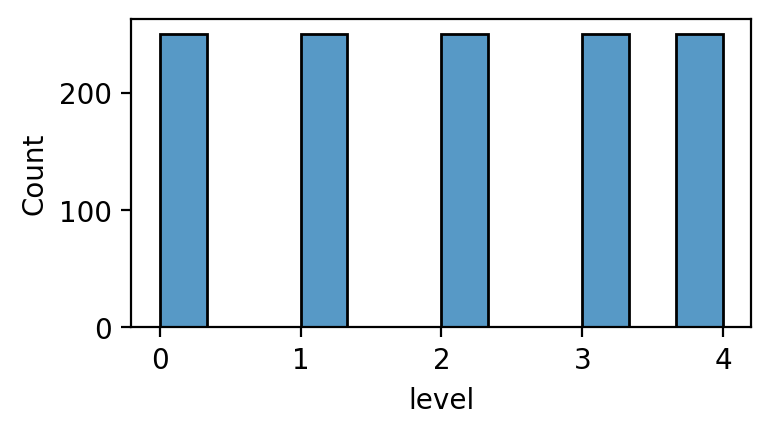

In [124]:
plt.figure(figsize=(4,2))
sns.histplot(train_data["level"])

In [125]:
from sklearn.model_selection import StratifiedKFold

sgkf = StratifiedKFold(n_splits=CFG.N_folds, random_state=CFG.seed, shuffle=True)
for i, (train_index, test_index) in enumerate(sgkf.split(train_data["image"].values, train_data["level"].values)):
    train_data.loc[test_index, "fold"] = i

In [126]:
def create_model():
    model = timm.create_model(CFG.model_name, num_classes=NUM_CLASSES, pretrained=True)

#     model = models.resnet50(models.ResNet50_Weights.SENTINEL2_ALL_DINO)
#     wd = torch.concat([model.conv1.weight[:, :13, ...], model.conv1.weight[:, :7, ...]], dim=1)
#     model.conv1 = nn.Conv2d(20, 64, 7, 2, 3, bias=False)
#     model.conv1.weight = nn.Parameter(wd)
#     model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

    return model.to(device)

In [127]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

def get_embeddings(model, data_loader):
    model.eval()
    
    # remove the last layer (fc) of model to obtain embeddings
    model = nn.Sequential(*list(model.children())[:-1])
    
    features = []
    targets = []

    total_len = len(data_loader)
    tk0 = tqdm(enumerate(data_loader), total=total_len)
    with torch.no_grad():
        for step, (images, labels) in tk0:
            images = images.to(device)
            target = labels.to(device)

            embds = model(images)

            features.append(embds.detach().cpu())
            targets.append(target.detach().cpu())

    features = torch.cat(features, dim=0)
    targets = torch.cat(targets, dim=0)
    
    # store the embeddings for future use
    torch.save(features, os.path.join(wandb.run.dir, f"embeddings.pth"))
    torch.save(targets, os.path.join(wandb.run.dir, f"targets.pth"))

    return features, targets


def plot_tsne(embeddings, labels):
    # Apply t-SNE to the embeddings
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings.numpy())

    # Define the number of unique labels/classes
    num_classes = len(np.unique(labels.numpy()))
    # Create a custom color map with specific color transitions
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=num_classes)

    # Create a boundary norm with boundaries and colors
    norm = mcolors.BoundaryNorm(np.arange(-0.5, num_classes + 0.5, 1), cmap.N)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, norm=norm, alpha=0.7)
    colorbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
    colorbar.set_label('Severity Level')
    colorbar.set_ticklabels(np.arange(num_classes))  # Set discrete labels if needed
    plt.title('t-SNE of Image Embeddings with Discrete Severity Levels')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.savefig(os.path.join(wandb.run.dir, f"tsne.png"), dpi=300)


## Train folds

In [128]:
for FOLD in CFG.train_folds:
    seed_everything(CFG.seed)

    # PREPARE DATA
    fold_train_data = train_data[train_data["fold"] != FOLD].reset_index(drop=True)
    fold_valid_data = train_data[train_data["fold"] == FOLD].reset_index(drop=True)

    train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_train_data, transforms=train_transforms)
    valid_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, fold_valid_data, transforms=val_transforms)

    train_loader = DataLoader(
            train_dataset,
            batch_size=CFG.batch_size,
            shuffle=True,
            num_workers=CFG.workers,
            pin_memory=True,
            drop_last=True
        )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )

    # PREPARE MODEL, OPTIMIZER AND SCHEDULER
    model = create_model()
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):_}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, eta_min=1e-6, T_max =CFG.epochs * len(train_loader),
        )
    
    loss_criterion = nn.CrossEntropyLoss()

    # TRAIN FOLD
    best_score = 0
    
    wandb.run.tags = [f"fold_{FOLD}"]
    
    for epoch in range(0, CFG.epochs):
        train_loss, train_lr, train_auc, train_accuracy, train_precision = train_epoch(CFG, model, train_loader, loss_criterion, optimizer, scheduler, epoch)

        val_loss, val_auc, val_accuracy, val_precision = evaluate_model(CFG, model, valid_loader, loss_criterion, epoch)
        
        # Log metrics to wandb
        wandb.log({
            'train_loss': train_loss,
            'train_auc': train_auc,
            'train_accuracy': train_accuracy,
            'train_precision': train_precision,
            'val_loss': val_loss,
            'val_auc': val_auc,
            'val_accuracy': val_accuracy,
            'val_precision': val_precision,
            'learning_rate': train_lr[-1]  # Log the last learning rate of the epoch
        })

        if (val_auc > best_score):
            print(f"{style.GREEN}New best score: {best_score:.4f} -> {val_auc:.4f}{style.END}")
            best_score = val_auc
            torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'best_model_fold_{FOLD}.pth'))
            

    # plot a tsne plot of all the images using embeddings from the model
    full_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, transforms=val_transforms)
    loader = DataLoader(
        full_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.workers,
        pin_memory=True,
        drop_last=False,
    )
    
    features, targets = get_embeddings(model, loader)
    plot_tsne(features, targets)

Model parameters: 23_518_277


Epoch 0 training 15/15 [LR 0.004878] - loss: 1.5820: 100%|███████████████| 15/15 [01:01<00:00,  4.11s/it]

tensor([[0.1912, 0.2015, 0.2091, 0.2092, 0.1891],
        [0.1838, 0.1948, 0.2319, 0.2117, 0.1780],
        [0.1946, 0.1853, 0.2208, 0.2034, 0.1960],
        ...,
        [0.1003, 0.0522, 0.1093, 0.1353, 0.6030],
        [0.1742, 0.1444, 0.2062, 0.1649, 0.3103],
        [0.2703, 0.2004, 0.2783, 0.1506, 0.1004]], dtype=torch.float16)
Epoch 0: training loss = 1.5820 auc = 0.5763 accuracy = 0.2531 precision = 0.2708



100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.34s/it]
/home/aakash_ks.iitr/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 0: validation loss = 1.6651 auc = 0.5835 accuracy = 0.2320 precision = 0.1258
New best score: 0.0000 -> 0.5835


Epoch 1 training 15/15 [LR 0.004523] - loss: 1.4510: 100%|███████████████| 15/15 [01:03<00:00,  4.22s/it]


tensor([[0.2369, 0.1875, 0.1582, 0.2390, 0.1783],
        [0.4587, 0.1470, 0.1857, 0.1365, 0.0722],
        [0.3713, 0.2661, 0.1235, 0.1917, 0.0473],
        ...,
        [0.0685, 0.0739, 0.2422, 0.3052, 0.3103],
        [0.1266, 0.2389, 0.1923, 0.2808, 0.1617],
        [0.1069, 0.0852, 0.1837, 0.1511, 0.4731]], dtype=torch.float16)


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [ ]:
wandb.finish()